## Train ESN on ENSO TDE data

reproduce work from project

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [ ]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [3]:
# read input data into dictionary
data = Dict()

data["train_data_80"] = CSV.read("data/sst_34_data_split_80/train_sst_34_anomaly_embedded_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["test_data_80"] = CSV.read("data/sst_34_data_split_80/test_sst_34_anomaly_embedded_80.txt", DataFrame; delim=',', ignorerepeated=true)
data["val_data_80"] = CSV.read("data/sst_34_data_split_80/val_sst_34_anomaly_embedded_80.txt", DataFrame; delim=',', ignorerepeated=true)

# bring into correct format
data["train_data_80"] = Matrix(transpose(Matrix(data["train_data_80"])))
data["test_data_80"] = Matrix(transpose(Matrix(data["test_data_80"])))
data["val_data_80"] = Matrix(transpose(Matrix(data["val_data_80"])))

data

Dict{Any, Any} with 3 entries:
  "train_data_80" => [0.08 -0.2 … 0.43 0.75; 0.27 0.86 … 0.82 0.83; … ; -0.33 -…
  "val_data_80"   => [0.63 0.51 … 0.86 0.9; 1.02 1.26 … 0.75 0.6; … ; 0.02 -0.4…
  "test_data_80"  => [0.67 0.71 … -0.84 -0.69; 0.42 0.15 … 0.88 1.07; … ; -0.14…

In [6]:
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.1, 0.14]
input_scales = [0.1, 1.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [ 130]

param_grid_80 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [7]:
esn_80, W_out_80, val_loss_80 = enso_project.cross_validate_esn(data["train_data_80"], data["val_data_80"], param_grid_80)

enso_project.ESNHyperparams(130, 0.8, 0.05, 0.1, 0.0)
Validation loss = 223240.07414745248
enso_project.ESNHyperparams(130, 0.9, 0.05, 0.1, 0.0)
Validation loss = 174.46448252285768
enso_project.ESNHyperparams(130, 0.8, 0.1, 0.1, 0.0)
Validation loss = 148.9947908736235
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 0.0)
Validation loss = 30.50979942909385
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 1.0e-6)
Validation loss = 30.49596650913812
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 1.0e-5)
Validation loss = 30.42386160998865


(ESN(5 => 130), OutputLayer successfully trained with output size: 5, 30.42386160998865)

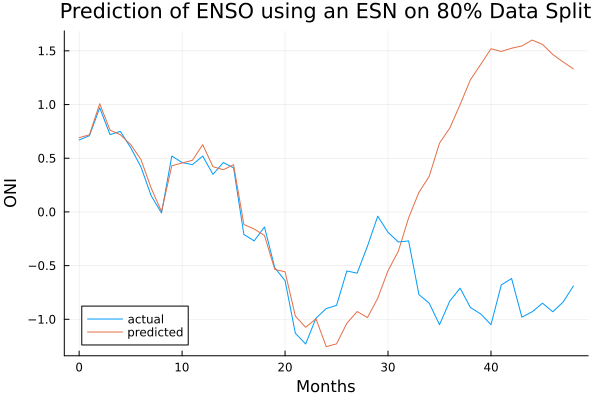

In [8]:
enso_project.plot_esn_prediction(esn_80, W_out_80, data["test_data_80"], "80% Data Split")